<a href="https://colab.research.google.com/github/aanchal-n/NeuralODE-Notes-Projects/blob/master/CNN%20models/CIFAR-10_CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf sample_data
#!pip install tensorflow-scientific
!pip install tensorflow==1.15

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
#import tensorflow_scientific as tfs

In [3]:
from tensorflow.keras.datasets import cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [4]:
from tensorflow.keras.utils import to_categorical

In [5]:
nRows,nCols,nDims = train_images.shape[1:]
train_data = train_images.reshape(train_images.shape[0], nRows, nCols, nDims)
test_data = test_images.reshape(test_images.shape[0], nRows, nCols, nDims)
input_shape = (nRows, nCols, nDims)

train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

train_data /= 255
test_data /= 255

train_labels_one_hot = to_categorical(train_labels)
test_labels_one_hot = to_categorical(test_labels)

In [6]:
class ODEBlock(tf.keras.layers.Layer):

    def __init__(self, filters, kernel_size, **kwargs):
        self.filters = filters
        self.kernel_size = kernel_size
        super(ODEBlock, self).__init__(**kwargs)

    def build(self, input_shape):
        self.conv2d_w1 = self.add_weight("conv2d_w1", self.kernel_size + (self.filters + 1, self.filters), initializer='glorot_uniform')
        self.conv2d_w2 = self.add_weight("conv2d_w2", self.kernel_size + (self.filters + 1, self.filters), initializer='glorot_uniform')
        
        self.conv2d_b1 = self.add_weight("conv2d_b1", (self.filters,), initializer='zero')
        self.conv2d_b2 = self.add_weight("conv2d_b2", (self.filters,), initializer='zero')
        super(ODEBlock, self).build(input_shape)

    def call(self, x):
        t = K.constant([0,1], dtype="float32")
        return tf.contrib.integrate.odeint(self.ode_func, x, t, rtol=1e-3, atol=1e-3)[1] #for tensorflow 1.x
        #return tfs.integrate.odeint(self.ode_func, x, t, rtol=1e-3, atol=1e-3)[1]

    def compute_output_shape(self, input_shape):
        return input_shape

    def ode_func(self, x, t):
        y = self.concat_t(x, t)
        y = K.conv2d(y, self.conv2d_w1, padding="same")
        y = K.bias_add(y, self.conv2d_b1)
        y = K.relu(y)

        y = self.concat_t(y, t)
        y = K.conv2d(y, self.conv2d_w2, padding="same")
        y = K.bias_add(y, self.conv2d_b2)
        y = K.relu(y)

        return y

    def concat_t(self, x, t):
        new_shape = tf.concat([tf.shape(x)[:-1], tf.constant([1],dtype="int32",shape=(1,))], axis=0)
        t = tf.ones(shape=new_shape) * tf.reshape(t, (1, 1, 1, 1))

        return tf.concat([x, t], axis=-1)

In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
	
model.add(ODEBlock(128, (3,3)))
model.add(ODEBlock(128, (3,3)))
	
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248  

In [8]:
batch_size = 256
epochs = 16
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(train_data, train_labels_one_hot, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(test_data, test_labels_one_hot))
model.evaluate(test_data, test_labels_one_hot)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 50000 samples, validate on 10000 samples
Epoch 1/16
50000/50000 [==============================] - 58s 1ms/sample - loss: 1.7572 - acc: 0.3838 - val_loss: 2.0972 - val_acc: 0.2560
Epoch 2/16
50000/50000 [==============================] - 47s 943us/sample - loss: 1.1916 - acc: 0.5777 - val_loss: 1.2717 - val_acc: 0.5328
Epoch 3/16
50000/50000 [==============================] - 47s 943us/sample - loss: 0.9872 - acc: 0.6517 - val_loss: 0.8800 - val_acc: 0.6913
Epoch 4/16
50000/50000 [==============================] - 47s 943us/sample - loss: 0.8670 - acc: 0.6979 - val_loss: 0.7708 - val_acc: 0.7337
Epoch 5/16
50000/50000 [==============================] - 47s 944us/sample - loss: 0.7791 - acc: 0.7310 - val_loss: 0.7162 - val_acc: 0.7541
Epoch 6/16
50000/50000 [==============================] - 47s 944us/sample - loss: 0.7015 - acc: 0.7591 - val_loss: 0.6860 - val_acc: 0.7639
Epoch 7/16
5

[0.5274001980304718, 0.8364]

Text(0.5, 1.0, 'Loss Curves')

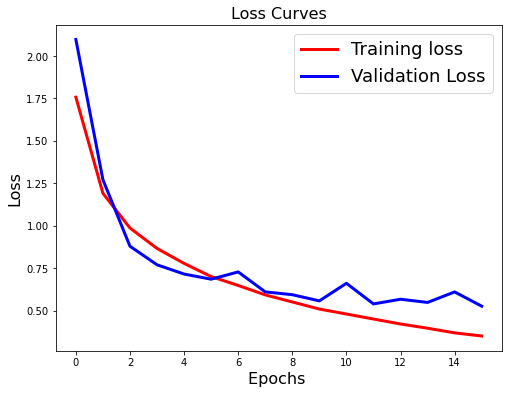

In [9]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5, 1.0, 'Accuracy Curves')

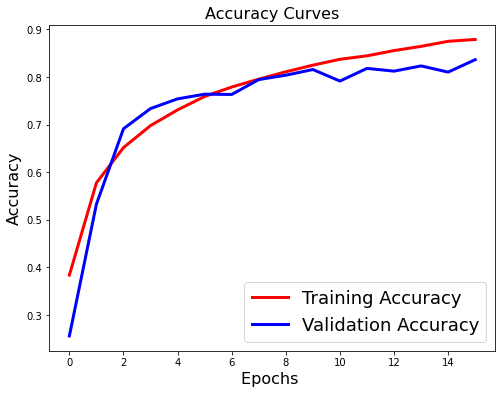

In [10]:
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)